In [112]:
import time
import qiskit as qs
from pyquil import Program
from pyquil.gates import *
from math import pi
from Mappings import *
import matplotlib.pyplot as plt

# Quil $\to$ Qasm

In [99]:
class QQConverter:
    """
    Given a .quil file with directory `in_dir`, creates 
    the corresponding .qasm file in the same directory.
    """  
    def __init__(self, in_dir):
        self.handlers = get_handlers(self)

        self.qasm = []; self.qubits = 0
        with open(in_dir) as quil:
            for line in quil:
                self.process(line.split())

        if self.qubits:
            self.qasm.insert(0, 'qreg q[{}];'.format(self.qubits))

        # Adding preamble
        self.qasm.insert(0, 'include \"qelib1.inc\";')
        self.qasm.insert(0, 'OPENQASM 2.0;')

        out_dir = in_dir.replace('.quil', '.qasm')
        with open(out_dir, 'w') as f:
            f.write('\n'.join(self.qasm))

    def process(self, args):
        """
        Maps each command to its respective handler
        """
        if args: 
            name = args[0].split('(')[0]
            self.handlers[name](*args)
        else: self.qasm.append('')
            
    def get_qasm_str(self):
        return '\n'.join(self.qasm)

    ##################
    # Command Handlers
    ##################
    def simple_gate(self, name, *qs):
        """
        Handles commands of the form `gatename q0 q1 ... qk`
        """
        if name not in NAME_MAP: return
        qasm_line = NAME_MAP[name]
        for idx, q in enumerate(qs):
            end = ';' if idx == len(qs)-1 else ','
            qasm_line += ' q[{}]{}'.format(q, end)
        self.qasm.append(qasm_line)

        # Updates maximum qubit index
        max_q = max([int(q) for q in qs]) + 1
        if max_q > self.qubits:
            self.qubits = max_q

    def param_gate(self, id_, *qs):
        """
        Handles commands of the form `gatename(param) q0 q1 ... qk`
        """
        name = id_.split('(')[0]
        if name not in NAME_MAP: return
        qasm_line = id_.replace(name, NAME_MAP[name])
        for idx, q in enumerate(qs):
            end = ';' if idx == len(qs)-1 else ','
            qasm_line += ' q[{}]{}'.format(q, end)
        self.qasm.append(qasm_line)

        # Updates maximum qubit index
        max_q = max([int(q) for q in qs]) + 1
        if max_q > self.qubits:
            self.qubits = max_q

    def declare(self, _, id_, mem):
        """
        Handles `DECLARE id_ type[size]`
        """
        size = ''.join(filter(str.isdigit, mem.split('[')[1]))
        qasm_line = 'creg {}[{}];'.format(id_, size)
        self.qasm.append(qasm_line)

    def measure(self, _, q, c):
        """
        Handles `MEASURE q c`
        """
        qasm_line = 'measure q[{}] -> {};'.format(q, c)
        self.qasm.append(qasm_line)

    def reset(self, _, idx=None):
        """
        `RESET`: resets all qubits
        `RESET idx`: resets qubit `idx`
        """
        if idx == None:
            for i in range(self.qubits):
                self.qasm.append('reset q[{}];'.format(i))
        else:
            self.qasm.append('reset q[{}];'.format(idx))

    def comment(self, *args):
        self.qasm.append(' '.join(args).replace('#', '//'))

## Hello World

In [54]:
p_hw = Program()
ro = p_hw.declare('ro', 'BIT', 1)
p_hw += H(0)
p_hw += X(0)
p_hw += MEASURE(0, ro[0])

out_file = open('data/tests/hw.quil', 'w')
print(p_hw); print(p_hw, file=out_file)
out_file.close()

DECLARE ro BIT[1]
H 0
X 0
MEASURE 0 ro[0]



In [55]:
qq = QQConverter(in_dir = 'data/tests/hw.quil')
qasm = qq.get_qasm_str()
print(qasm)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg ro[1];
h q[0];
x q[0];
measure q[0] -> ro[0];



In [61]:
qc = qs.QuantumCircuit.from_qasm_str(qasm)
print(qc)

backend_sim = qs.Aer.get_backend('qasm_simulator')
qs.execute(qc, backend_sim).result().get_counts(qc)

        ┌───┐┌───┐┌─┐
q_0: |0>┤ H ├┤ X ├┤M├
        └───┘└───┘└╥┘
ro_0: 0 ═══════════╩═
                     


{'0': 504, '1': 520}

In [108]:
def test_quil(quil, dir_):
    print("~~~ QUIL Input ~~~")
    if quil:
        out_file = open(dir_, 'w')
        print(quil); print(quil, file=out_file)
        out_file.close()
    else:
        with open(dir_) as f:
            for line in f: print(line, end='')
    qasm = QQConverter(in_dir=dir_).get_qasm_str()
    print("~~~ QASM Output ~~~")
    print(qasm)
    qc = qs.QuantumCircuit.from_qasm_str(qasm)
    print(qc)

    backend_sim = qs.Aer.get_backend('qasm_simulator')
    print(qs.execute(qc, backend_sim).result().get_counts(qc))

## Three-Qubit Quantum Fourier Transform

In [189]:
p_qft = Program()
ro = p_qft.declare('ro', 'BIT', 3)
p_qft += H(2)
p_qft += CPHASE(pi/2.0, 2, 1)
p_qft += H(1)
p_qft += CPHASE(pi/4.0, 2, 0)
p_qft += CPHASE(pi/2.0, 1, 0)
p_qft += H(0)
p_qft += SWAP(0, 2)
p_qft += MEASURE(0, ro[0])
p_qft += MEASURE(1, ro[1])
p_qft += MEASURE(2, ro[2])

test_quil(p_qft, 'data/tests/qft.quil')

~~~ QUIL Input ~~~
DECLARE ro BIT[3]
H 2
CPHASE(pi/2) 2 1
H 1
CPHASE(pi/4) 2 0
CPHASE(pi/2) 1 0
H 0
SWAP 0 2
MEASURE 0 ro[0]
MEASURE 1 ro[1]
MEASURE 2 ro[2]

~~~ QASM Output ~~~
OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg ro[3];
h q[2];
crz(pi/2) q[2], q[1];
h q[1];
crz(pi/4) q[2], q[0];
crz(pi/2) q[1], q[0];
h q[0];
swap q[0], q[2];
measure q[0] -> ro[0];
measure q[1] -> ro[1];
measure q[2] -> ro[2];

                                ┌────────────┐┌────────────┐┌───┐   ┌─┐      
q_0: |0>────────────────────────┤ Rz(0.7854) ├┤ Rz(1.5708) ├┤ H ├─X─┤M├──────
             ┌────────────┐┌───┐└─────┬──────┘└─────┬──────┘└───┘ │ └╥┘   ┌─┐
q_1: |0>─────┤ Rz(1.5708) ├┤ H ├──────┼─────────────■─────────────┼──╫────┤M├
        ┌───┐└─────┬──────┘└───┘      │                           │  ║ ┌─┐└╥┘
q_2: |0>┤ H ├──────■──────────────────■───────────────────────────X──╫─┤M├─╫─
        └───┘                                                        ║ └╥┘ ║ 
ro_0: 0 ════════════════════════════════

# Scalability

Text(0.5, 1.0, 'Linear Complexity of QUIL-QASM Translation')

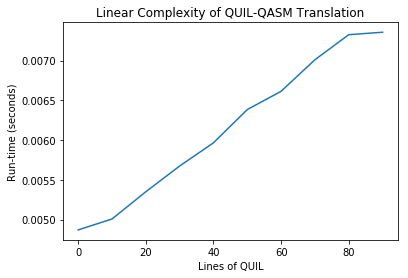

In [188]:
times = [0.004870668129300801, 0.005008042844565352, 0.005350470007670083, 0.005673934218179966, 0.005965671950320939, 0.006383586251672568, 0.006613694387965552, 0.0070100930314538346, 0.007325169782234298, 0.007356166916224538]
plt.plot([10*x for x in range(10)], times)
plt.xlabel("Lines of QUIL")
plt.ylabel("Run-time (seconds)")
plt.title("Linear Complexity of QUIL-QASM Translation")

In [109]:
test_quil(None, 'data/tests/scale.quil')

~~~ QUIL Input ~~~
DECLARE ro BIT[5]
H 0
H 1
H 2
H 3
H 4
X 0
PHASE(4.3806879867915676) 0
X 0
PHASE(4.3806879867915676) 0
CPHASE(2.1903439933957838) 0 4
CPHASE(2.1903439933957838) 1 4
CPHASE(2.1903439933957838) 2 4
CPHASE(2.1903439933957838) 3 4
H 0
RZ(-4.1246139468778829) 0
H 0
H 1
RZ(-4.1246139468778829) 1
H 1
H 2
RZ(-4.1246139468778829) 2
H 2
H 3
RZ(-4.1246139468778829) 3
H 3
H 4
RZ(-4.1246139468778829) 4
H 4
X 0
PHASE(9.564271161482031) 0
X 0
PHASE(9.564271161482031) 0
CPHASE(4.7821355807410155) 0 4
CPHASE(4.7821355807410155) 1 4
CPHASE(4.7821355807410155) 2 4
CPHASE(4.7821355807410155) 3 4
H 0
RZ(-3.6447465906867933) 0
H 0
H 1
RZ(-3.6447465906867933) 1
H 1
H 2
RZ(-3.6447465906867933) 2
H 2
H 3
RZ(-3.6447465906867933) 3
H 3
H 4
RZ(-3.6447465906867933) 4
H 4
X 0
PHASE(8.6554770455449344) 0
X 0
PHASE(8.6554770455449344) 0
CPHASE(4.3277385227724672) 0 4
CPHASE(4.3277385227724672) 1 4
CPHASE(4.3277385227724672) 2 4
CPHASE(4.3277385227724672) 3 4
H 0
RZ(-4.2319533284265045) 0
H 0
H 1
RZ(

{'01101': 36, '11100': 28, '00100': 58, '00011': 6, '00110': 4, '11111': 43, '10111': 31, '01001': 7, '00001': 51, '10010': 1, '11110': 28, '10100': 3, '11000': 3, '10000': 33, '01010': 7, '01100': 2, '11010': 26, '01110': 33, '00101': 6, '01111': 115, '00000': 110, '10110': 32, '11011': 40, '00010': 59, '00111': 45, '10101': 40, '11001': 25, '11101': 31, '10011': 35, '01011': 38, '10001': 3, '01000': 45}
